In [1]:
import pandas as pd
import os
import numpy as np
import epiweeks
import datetime
import requests
import zipfile
import csv
from contextlib import ExitStack
import progressbar as pbar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import warnings
from itertools import product
warnings.filterwarnings('ignore')
from scipy import optimize

In [2]:
IFRs = {'O\'Driscoll': {'00-34': [0.009, 0.007, 0.010],
                        '35-59': [0.122, 0.115, 0.128],
                        '60-79': [0.992, 0.942, 1.045],
                        '80+': [7.274, 6.909, 7.656],
                        'TOTAL': [0.756, 0.717, 0.796]},
        'Verity': {'00-34': [0.041, 0.019, 0.110],
                   '35-59': [0.349, 0.194, 0.743],
                   '60-79': [2.913, 1.670, 5.793],
                   '80+': [7.800, 3.800, 13.30],
                   'TOTAL': [1.296, 0.694, 2.453]},
        'Perez-Saez': {'00-34': [0.007, 0.003, 0.013],
                       '35-59': [0.070, 0.047, 0.097],
                       '60-79': [3.892, 2.985, 5.145],
                       '80+': [5.600, 4.300, 7.400],
                       'TOTAL': [1.254, 0.959, 0.661]},
        'Levin': {'00-34': [0.016, 0.014, 0.020],
                  '35-59': [0.226, 0.212, 0.276],
                  '60-79': [2.491, 2.294, 3.266],
                  '80+': [15.61, 12.20, 19.50],
                  'TOTAL': [1.687, 1.407, 2.139]}}

In [3]:
today = datetime.date.today().strftime("%d-%m-%Y")
data_dir_path = f'data/World/{today}'

In [96]:
population = pd.read_csv(f'{data_dir_path}/Germany/old_population.csv')
population = population[~population['Age group'].isin(['UNK', 'Y_OPEN'])]
population = population[population['Region'] == 'DE']
population['Age group'] = population['Age group'].replace({'TOTAL': 'YTOTAL', 'Y_LT1': 'Y0'}).apply(lambda x: x[1:])
population = population[~population['Age group'].isin(['TOTAL'])]
population = population[population['Year'] == 2020]
population = population[population['Sex'] == 'T']
population['Age group'] = population['Age group'].apply(lambda x: int(x))
population = population.drop(columns=['Region', 'Year', 'Sex']).set_index('Age group').sort_index()
population

,Value
Age group,
0,774870
1,794132
2,802415
3,807816
4,782143
...,...
95,52596
96,37449
97,26814


In [145]:
T = population.to_numpy()
def func(x, a, b, c):
    x1, x2 = x
    P = np.zeros(len(x1))
    for j in range(len(x1)):
        for i in range(int(x1[j]), int(x2[j])):
            P[j] += T[i] / np.sum(T[int(x1[j]): int(x2[j])]) * (np.exp(a*i + b) + c)
            
    return P

x1 = np.array(4 * [0, 35, 60, 80, 0])
x2 = np.array(4 * [35, 60, 80, 100, 100])
y = np.array([IFRs['O\'Driscoll']['00-34'][0] / 100,
              IFRs['O\'Driscoll']['35-59'][0] / 100,
              IFRs['O\'Driscoll']['60-79'][0] / 100,
              IFRs['O\'Driscoll']['80+'][0] / 100,
              IFRs['O\'Driscoll']['TOTAL'][0] / 100,
              IFRs['Verity']['00-34'][0] / 100,
              IFRs['Verity']['35-59'][0] / 100,
              IFRs['Verity']['60-79'][0] / 100,
              IFRs['Verity']['80+'][0] / 100,
              IFRs['Verity']['TOTAL'][0] / 100,
              IFRs['Perez-Saez']['00-34'][0] / 100,
              IFRs['Perez-Saez']['35-59'][0] / 100,
              IFRs['Perez-Saez']['60-79'][0] / 100,
              IFRs['Perez-Saez']['80+'][0] / 100,
              IFRs['Perez-Saez']['TOTAL'][0] / 100,
              IFRs['Levin']['00-34'][0] / 100,
              IFRs['Levin']['35-59'][0] / 100,
              IFRs['Levin']['60-79'][0] / 100,
              IFRs['Levin']['80+'][0] / 100,
              IFRs['Levin']['TOTAL'][0] / 100,
             ])
alpha = optimize.curve_fit(func, xdata = (x1, x2), ydata = y)[0]
alpha

array([ 8.05287225e-02, -9.25960452e+00, -1.57663719e-03])

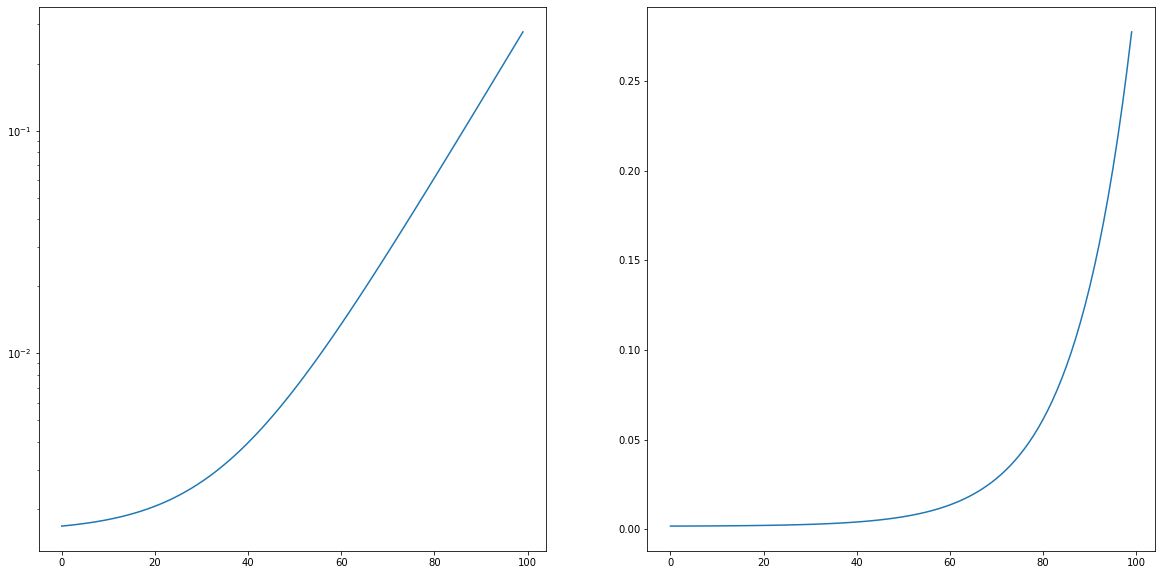

In [146]:
age = np.arange(0, 100)
ifr = np.exp(alpha[0]*age + alpha[1]) + np.abs(alpha[2])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(age, ifr)
ax[0].set_yscale('log')
ax[1].plot(age, ifr)
plt.show()

In [153]:
est_IFR = {}
age_group = 5
for start, stop in zip(range(0, 80 + 1, age_group), range(5, 85 + 1, age_group)):
    P = 0.0
    for i in range(start, stop):
        P += T[i] / np.sum(T[start: stop]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
    est_IFR[f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
P = 0.0
for i in range(85, 100):
    P += T[i] / np.sum(T[85: ]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
est_IFR[f'85+'] = float(P) * 100.0

P = 0.0
for i in range(0, 100):
    P += T[i] / np.sum(T) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
est_IFR[f'TOTAL'] = float(P) * 100.0

with open(f'{data_dir_path}/ifr_5_years_age_group.json', 'w') as file:
    json.dump(est_IFR, file, indent=4)
est_IFR

{'00-04': 0.16892477244016268,
 '05-09': 0.17447378635410396,
 '10-14': 0.18284335114913702,
 '15-19': 0.19551508035703635,
 '20-24': 0.21414126467181813,
 '25-29': 0.24248551474010616,
 '30-34': 0.28342854735542483,
 '35-39': 0.3463305055487589,
 '40-44': 0.4389207506343999,
 '45-49': 0.5835765607484612,
 '50-54': 0.7909662213763731,
 '55-59': 1.0975468908367356,
 '60-64': 1.560744521914534,
 '65-69': 2.2623553668256906,
 '70-74': 3.2583667753081356,
 '75-79': 4.914692810002588,
 '80-84': 7.100974194793379,
 '85+': 12.589013333500484,
 'TOTAL': 1.5678411755473163}

In [154]:
est_IFR = {}
P = 0.0
for start, stop in zip([0, 35, 60, 80, 0] , [35, 60, 80, 100, 100]):
    P = 0.0
    for i in range(start, stop):
        P += T[i] / np.sum(T[start: stop]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
    est_IFR[f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
est_IFR

{'00-34': 0.21441626549934312,
 '35-59': 0.683491201816728,
 '60-79': 2.8149555405698403,
 '80-99': 9.397182994756875,
 '00-99': 1.5678411755473163}

In [149]:
IFRs

{"O'Driscoll": {'00-34': [0.009, 0.007, 0.01],
  '35-59': [0.122, 0.115, 0.128],
  '60-79': [0.992, 0.942, 1.045],
  '80+': [7.274, 6.909, 7.656],
  'TOTAL': [0.756, 0.717, 0.796]},
 'Verity': {'00-34': [0.041, 0.019, 0.11],
  '35-59': [0.349, 0.194, 0.743],
  '60-79': [2.913, 1.67, 5.793],
  '80+': [7.8, 3.8, 13.3],
  'TOTAL': [1.296, 0.694, 2.453]},
 'Perez-Saez': {'00-34': [0.007, 0.003, 0.013],
  '35-59': [0.07, 0.047, 0.097],
  '60-79': [3.892, 2.985, 5.145],
  '80+': [5.6, 4.3, 7.4],
  'TOTAL': [1.254, 0.959, 0.661]},
 'Levin': {'00-34': [0.016, 0.014, 0.02],
  '35-59': [0.226, 0.212, 0.276],
  '60-79': [2.491, 2.294, 3.266],
  '80+': [15.61, 12.2, 19.5],
  'TOTAL': [1.687, 1.407, 2.139]}}